In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import subprocess
import pandas as pd

In [3]:
## Function to find event files/lc files from the directory 
def find_event_files(base_directory):
    event_files = []
    
    # Regular expression to match the pattern ObsID/xti/event_cl/
    obsid_pattern = re.compile(r'^\d{10}$')
    
    # Regular expressions to match the specific filename patterns
    file_pattern = re.compile(r'^ni\d{10}_0mpu7_cl_(night|daynotconsidered)_barycorr_orbit_piexpiex_yes.evt$')

    for obsid_dir in os.listdir(base_directory):
        obsid_path = os.path.join(base_directory, obsid_dir)

        # Check if it's a directory and matches the 10-digit ObsID pattern
        if os.path.isdir(obsid_path) and obsid_pattern.match(obsid_dir):
            #print(f"Found 10-digit ObsID folder: {obsid_dir}")

            # Look for files in this directory matching the .evt pattern
            for file in os.listdir(obsid_path):
                if file_pattern.match(file):
                    full_path = os.path.join(obsid_path, file)
                    event_files.append(full_path)
                    # print(f"Found .evt file: {full_path}")

    return event_files

In [116]:
base_directory='./reduced_output'
input_period_file = 'all_lc_periods_evt_files_bary_orbit_piexpiex.txt'

test_input="/home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes.evt"
test_output="/home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_trial_phase_resolved_test.evt"



df = pd.read_csv(input_period_file, delimiter='\t')
# Filter out rows where period is "-none-"
df = df[df['Period'] != "-none-"]

# Convert the 'Period' column to float for valid entries
df['Period'] = df['Period'].astype(float)
df['LC_File_Path'] = df['LC_File_Path'].astype(str)

#Running the code to find event files
first_input_orbit_file_list=find_event_files(base_directory)
print("Total number of input event files found: ",len(first_input_orbit_file_list))
for first_input_file in first_input_orbit_file_list:
    first_input_file=test_input

    print("*******Adding Orbit Time from common reference******")
    print("Working on the file: ",first_input_file)

    obsid=first_input_file.split("/")[-2]
    
    first_output_file = first_input_file.replace(".evt", "_phase_added.evt")
    ## for xx231= 	298771202.000 and freq=0.1020354022
    ## for xx261= 303782402.200 added 0.2 sec and freq= 0.1021189686
    first_ftcalc_command=f'ftcalc infile={first_input_file+"[events]"} outfile={first_output_file} column=ORBIT_REF_TIME expression="(ORBITTIME-(298425602.300))" clobber=yes'
    try:
        subprocess.run(first_ftcalc_command,shell=True, check=True)
        print("Successfully saved as: ",first_output_file)
    except subprocess.CalledProcessError as e:
        print(f"Error processing {first_input_file}: {e}")
    

    print("*******Adding Phase column in same file******")
    period=df['Period'][df['LC_File_Path']==obsid].values[0]
    period=9.80052
    freq=1/period
    print("Period is: ",period)
    second_input_file=first_output_file
    second_output_file=first_output_file
    second_ftcalc_command=f'ftcalc infile={second_input_file+"[events]"} outfile={second_output_file} column=PHASE expression="({freq}*(ORBIT_REF_TIME))%1" clobber=YES'                 
    
    try:
        subprocess.run(second_ftcalc_command,shell=True, check=True)
        print("Successfully saved as: ",second_output_file)
    except subprocess.CalledProcessError as e:
        print(f"Error processing {first_input_file}: {e}")

    break

Total number of input event files found:  66
*******Adding Orbit Time from common reference******
Working on the file:  /home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes.evt
Successfully saved as:  /home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt
*******Adding Phase column in same file******
Period is:  9.80052
Successfully saved as:  /home/supremekai/thesis/J0243_6p6124/nicer/reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt


In [117]:
hdul=fits.open('./reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt')
hdul.info()

Filename: ./reduced_output/6050390231/ni6050390231_0mpu7_cl_night_barycorr_orbit_piexpiex_yes_phase_added.evt
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      32   ()      
  1  EVENTS        1 BinTableHDU    443   1657510R x 18C   [1D, 1B, 1B, 1I, 1I, 1B, 1B, 8X, 1K, I, J, 1I, 1I, 1E, 1D, 1D, 1D, 1D]   
  2  FPM_SEL       1 BinTableHDU    128   2487R x 3C   [1D, 56B, 56I]   
  3  GTI           1 BinTableHDU    258   5R x 2C   [D, D]   
  4  GTI_DET10     1 BinTableHDU    224   4R x 2C   [D, D]   
  5  GTI_DET21     1 BinTableHDU    225   2R x 2C   [D, D]   
  6  GTI_DET42     1 BinTableHDU    225   37R x 2C   [D, D]   
  7  GTI_DET43     1 BinTableHDU    225   3R x 2C   [D, D]   
  8  GTI_MPU0      1 BinTableHDU    264   24R x 2C   [D, D]   
  9  GTI_MPU1      1 BinTableHDU    257   38R x 2C   [D, D]   
 10  GTI_MPU2      1 BinTableHDU    261   37R x 2C   [D, D]   
 11  GTI_MPU3      1 BinTableHDU    264   3R x 2C   [D, D]   
 12  GTI_

In [118]:
events=hdul[1]

In [119]:
events.columns

ColDefs(
    name = 'TIME'; format = '1D'; unit = 's'; disp = 'F20.9'
    name = 'RAWX'; format = '1B'; unit = 'pixel'; coord_type = 'RAWX'; coord_ref_point = 0; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'RAWY'; format = '1B'; unit = 'pixel'; coord_type = 'RAWY'; coord_ref_point = 0; coord_ref_value = 0.0; coord_inc = 1.0
    name = 'PHA'; format = '1I'; unit = 'chan'; null = -32768
    name = 'PHA_FAST'; format = '1I'; unit = 'chan'; null = -32768
    name = 'DET_ID'; format = '1B'; disp = 'I2.2'
    name = 'DEADTIME'; format = '1B'; unit = 's'; bscale = 6.202e-07; bzero = 3.101e-07; disp = 'F11.9'
    name = 'EVENT_FLAGS'; format = '8X'
    name = 'TICK'; format = '1K'
    name = 'MPU_A_TEMP'; format = 'I'; unit = 'Celsius'; null = -1; bscale = 0.10600843; bzero = -273.42105; disp = 'F6.3'
    name = 'MPU_UNDER_COUNT'; format = 'J'; null = -1
    name = 'PI_FAST'; format = '1I'; unit = 'chan'; null = -32768
    name = 'PI'; format = '1I'; unit = 'chan'; null = -32768
    name

In [120]:
phase=events.data['PHASE']

In [121]:
phase.size

1657510

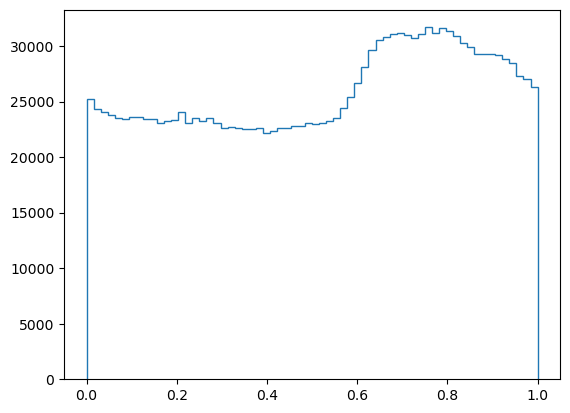

In [122]:
listed=plt.hist(phase,bins=64,histtype='step')
# plt.ylim(13000)

In [123]:
len(listed[1]),len(listed[0])

(65, 64)

In [124]:
listed[1]

array([4.32002707e-07, 1.56254225e-02, 3.12504130e-02, 4.68754035e-02,
       6.25003941e-02, 7.81253846e-02, 9.37503751e-02, 1.09375366e-01,
       1.25000356e-01, 1.40625347e-01, 1.56250337e-01, 1.71875328e-01,
       1.87500318e-01, 2.03125309e-01, 2.18750299e-01, 2.34375290e-01,
       2.50000280e-01, 2.65625271e-01, 2.81250261e-01, 2.96875252e-01,
       3.12500242e-01, 3.28125233e-01, 3.43750223e-01, 3.59375214e-01,
       3.75000204e-01, 3.90625195e-01, 4.06250185e-01, 4.21875176e-01,
       4.37500166e-01, 4.53125157e-01, 4.68750147e-01, 4.84375138e-01,
       5.00000128e-01, 5.15625119e-01, 5.31250109e-01, 5.46875100e-01,
       5.62500091e-01, 5.78125081e-01, 5.93750072e-01, 6.09375062e-01,
       6.25000053e-01, 6.40625043e-01, 6.56250034e-01, 6.71875024e-01,
       6.87500015e-01, 7.03125005e-01, 7.18749996e-01, 7.34374986e-01,
       7.49999977e-01, 7.65624967e-01, 7.81249958e-01, 7.96874948e-01,
       8.12499939e-01, 8.28124929e-01, 8.43749920e-01, 8.59374910e-01,
      

In [125]:
listed[0]

array([25196., 24321., 24088., 23746., 23486., 23455., 23581., 23646.,
       23401., 23387., 23103., 23277., 23377., 24013., 23039., 23508.,
       23236., 23485., 23060., 22606., 22751., 22619., 22484., 22546.,
       22625., 22173., 22350., 22605., 22579., 22771., 22837., 23028.,
       22938., 23094., 23253., 23540., 24446., 25384., 26684., 28098.,
       29647., 30566., 30802., 31055., 31192., 31004., 30688., 31095.,
       31682., 31156., 31600., 31382., 30884., 30294., 29880., 29269.,
       29266., 29235., 29199., 28782., 28431., 27265., 27032., 26288.])

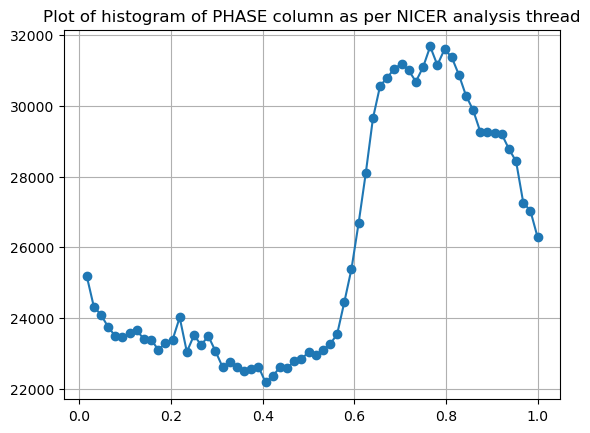

In [126]:
### Plot the profile as a line plot
plt.plot(listed[1][1:],listed[0],'-o')
plt.title("Plot of histogram of PHASE column as per NICER analysis thread")
plt.grid()